In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import torch
from torch import vmap

from src.energies.base_prior import MeanFreePrior

from src.models.components.clipper import Clipper
from src.utils.data_utils import remove_mean

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [6]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
inverse_temp = 1.0

from src.energies.lennardjones_energy import LennardJonesEnergy
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/LJ13_temp_{inverse_temp}/test_split_LJ13-1000.npy",
    data_path_train= f"../../data/LJ13_temp_{inverse_temp}/train_split_LJ13-1000.npy",
    data_path_val= f"../../data/LJ13_temp_{inverse_temp}/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=inverse_temp
    )

In [7]:
t_07 = 0.7
target_temp_07 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/LJ13_temp_{t_07}/test_split_LJ13-1000.npy",
    data_path_train= f"../../data/LJ13_temp_{t_07}/train_split_LJ13-1000.npy",
    data_path_val= f"../../data/LJ13_temp_{t_07}/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=t_07
    )

t_08 = 0.8
target_temp_08 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/LJ13_temp_{t_08}/test_split_LJ13-1000.npy",
    data_path_train= f"../../data/LJ13_temp_{t_08}/train_split_LJ13-1000.npy",
    data_path_val= f"../../data/LJ13_temp_{t_08}/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=t_08
    )

## Function Definitions

In [9]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, next_u, logits):
    u = torch.rand(size=(1,), dtype=torch.float64)
    u = (u + 1/bs*torch.arange(bs)) % 1.0
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    return ids, None

In [23]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, noise_schedule):
        super().__init__()
        self.model = model
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, inverse_temp=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            epsilon_t = self.g(t, x).pow(2) / 2 

            nabla_Ut = self.model(t, x)
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)
            
            if resampling_interval is None:
                return  drift_X.detach(), drift_A.detach()
            
            drift_A = epsilon_t * (-nabla_Ut.pow(2).sum(-1) * (inverse_temp-1) * inverse_temp)
        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, diffusion_scale,
                                resampling_interval, inverse_temp, u_next):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, inverse_temp)
    drift_Xt = drift_Xt * dt * inverse_temp
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device) * diffusion_scale

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, u_next

    #resample based on the weights
    #choice, _ = sample_cat(x.shape[0], u_next, a_next)
    choice, u_next = sample_cat_sys(x.shape[0], u_next, a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next


def integrate_sde_coupled(sde, x0, t_span, dt, diffusion_scale, 
                          resampling_interval, inverse_temp):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, diffusion_scale,
                                                       resampling_interval, inverse_temp, u_next)
            x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, diffusion_scale=1.0,
                              resampling_interval=None, inverse_temp=1.0):
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        diffusion_scale=diffusion_scale,
        resampling_interval = resampling_interval,
        inverse_temp=inverse_temp
    )
    return samples[-1], weights

In [21]:
from src.models.components.score_estimator import estimate_grad_Rt
def reward_matching_loss(model,
                         energy,
                         x,
                         t,
                         noise_schedule,
                         num_mc_samples=100,
                         clipper=None,
    ):


    x.requires_grad = True
    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = estimate_grad_Rt(
        t,
        xt,
        energy,
        noise_schedule,
        num_mc_samples=num_mc_samples,
    ).detach()

    if clipper is not None:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Training

In [13]:
from src.models.components.noise_schedules import GeometricNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=2)
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.001, sigma_max=8)

prior samples torch.Size([2048, 39])


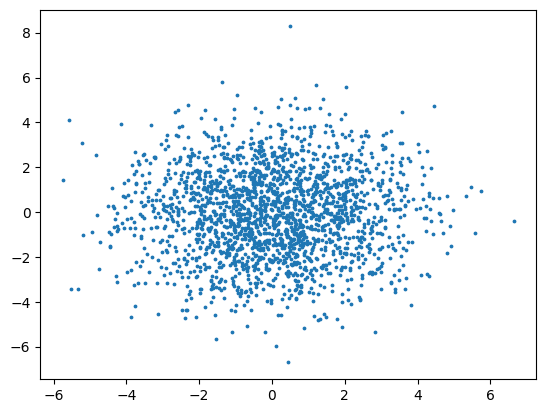

In [14]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(2048).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

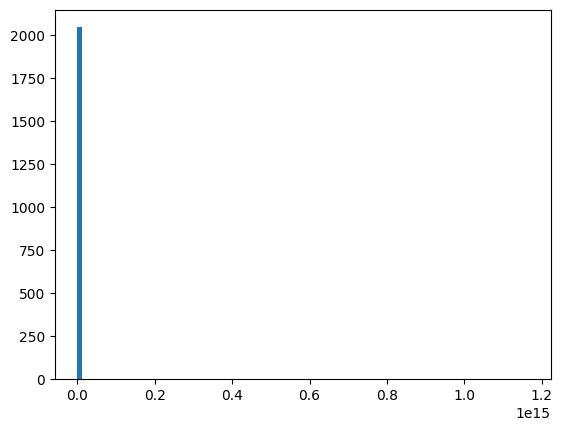

In [15]:
x1_enegry = target(x1_samples)
plt.hist(-x1_enegry.detach().cpu().numpy(), bins=100);

In [24]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [25]:
clipper = Clipper(
    should_clip_scores=True, should_clip_log_rewards=False, max_score_norm=20
)
clipper.energy_function = target

In [26]:
outer_epochs= 50
inner_epochs = 100

batch_size = 1024

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 1000

In [27]:
from src.models.components.egnn import EGNN_dynamics
model = EGNN_dynamics(n_particles=target.n_particles,
                      n_dimension=target.n_spatial_dim,
                      hidden_nf=64,
                      act_fn=torch.nn.SiLU(),
                      n_layers=3,
                      recurrent=True,
                      tanh=True,
                      attention=True,
                      condition_time=True,
                      agg='sum').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 | Loss 12.947145
Epoch 49 | Loss 9.796970
Epoch 98 | Loss 5.215781


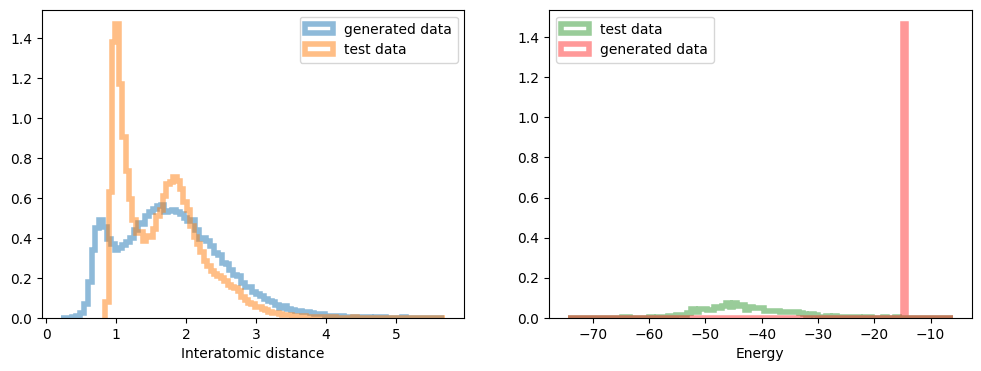

  2%|▏         | 1/50 [00:37<30:45, 37.66s/it]

Mean of Energy tensor(-352651.6250, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 17.578808
Epoch 49 | Loss 12.961186
Epoch 98 | Loss 13.613623


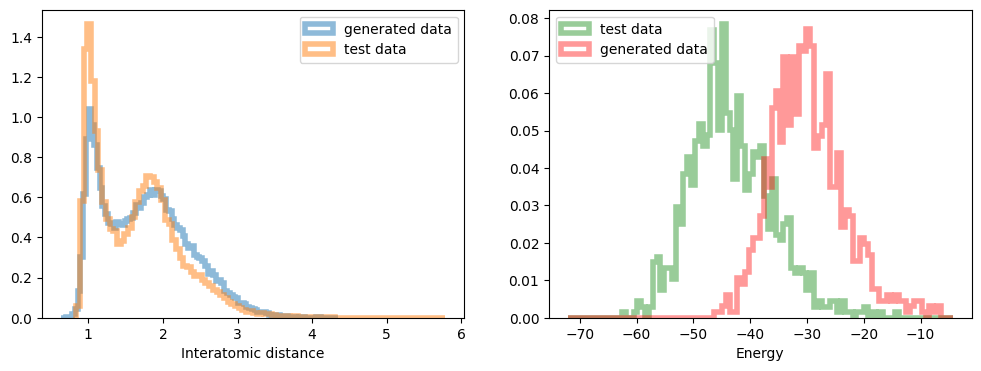

  4%|▍         | 2/50 [02:04<53:08, 66.42s/it]

Mean of Energy tensor(28.2250, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 25.556091
Epoch 49 | Loss 16.250786
Epoch 98 | Loss 15.125897


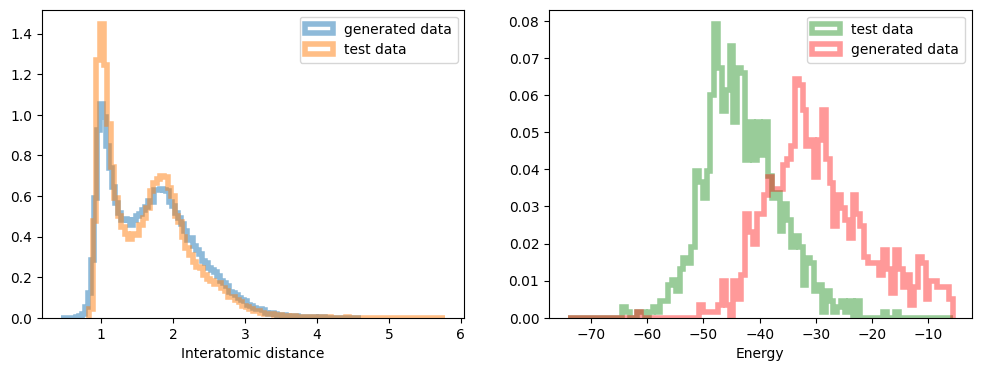

  6%|▌         | 3/50 [03:30<59:16, 75.66s/it]

Mean of Energy tensor(-20.4899, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 20.501104
Epoch 49 | Loss 18.633682
Epoch 98 | Loss 19.178062


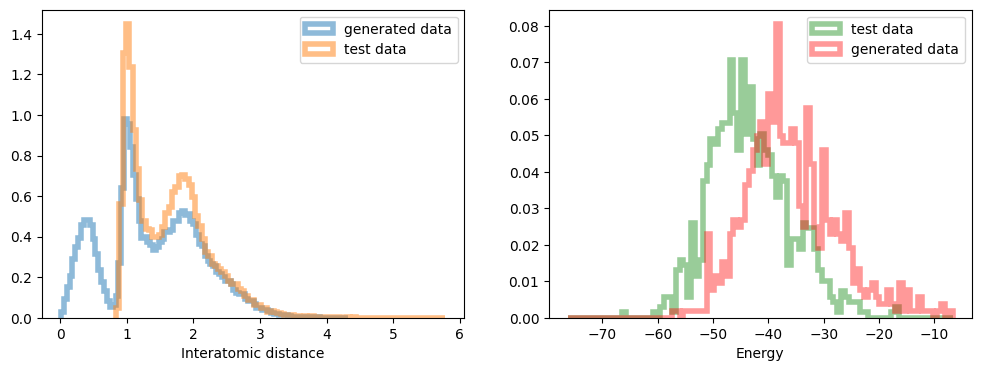

  8%|▊         | 4/50 [04:57<1:01:18, 79.97s/it]

Mean of Energy tensor(-4.6212e+21, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 23.576231
Epoch 49 | Loss 21.128393
Epoch 98 | Loss 20.734537


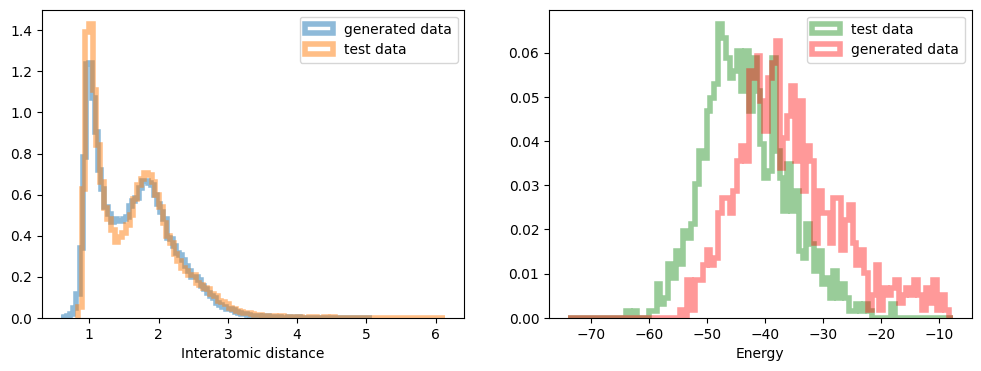

 10%|█         | 5/50 [06:23<1:01:43, 82.31s/it]

Mean of Energy tensor(25.4452, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 23.442183
Epoch 49 | Loss 22.698977
Epoch 98 | Loss 24.132927


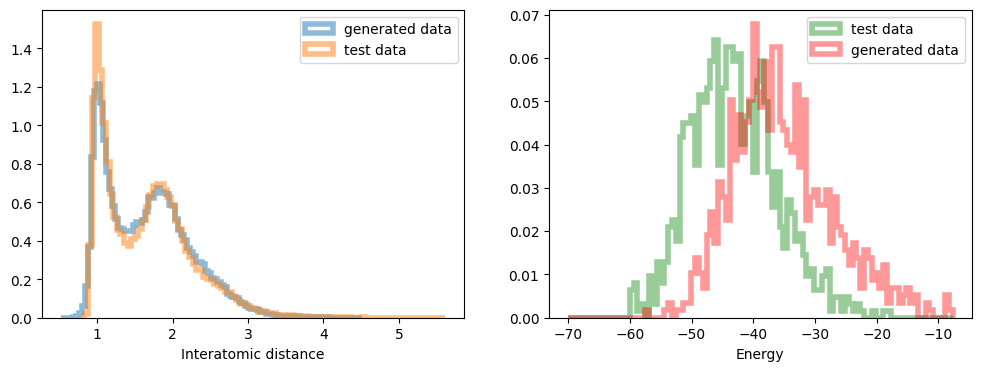

 12%|█▏        | 6/50 [07:50<1:01:25, 83.76s/it]

Mean of Energy tensor(24.1683, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 25.166611
Epoch 49 | Loss 24.729509
Epoch 98 | Loss 24.881582


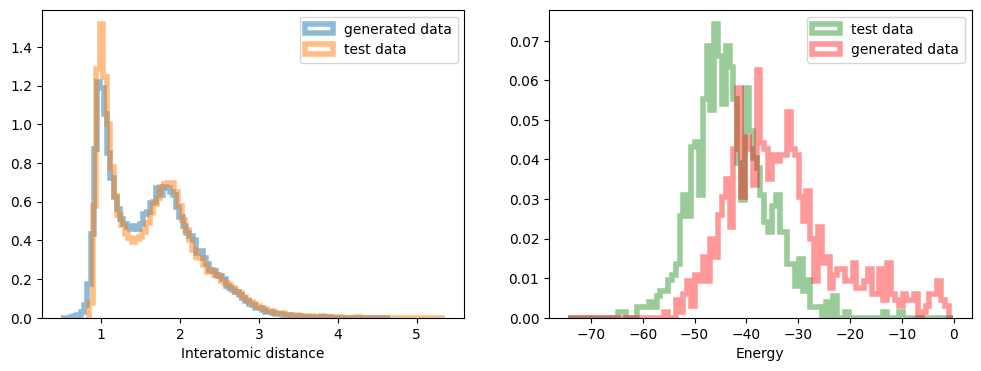

 14%|█▍        | 7/50 [09:16<1:00:39, 84.64s/it]

Mean of Energy tensor(8.9444, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 24.269581
Epoch 49 | Loss 24.699223
Epoch 98 | Loss 27.247120


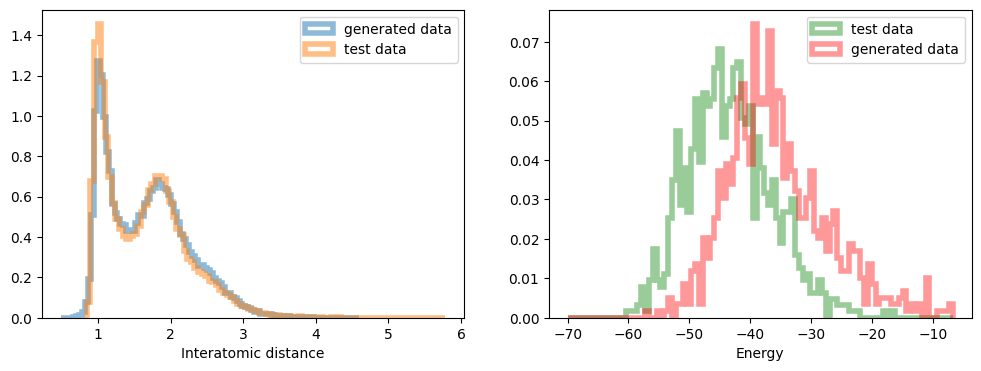

 16%|█▌        | 8/50 [10:44<59:59, 85.69s/it]  

Mean of Energy tensor(18.5241, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 24.577320
Epoch 49 | Loss 25.436146
Epoch 98 | Loss 26.003305


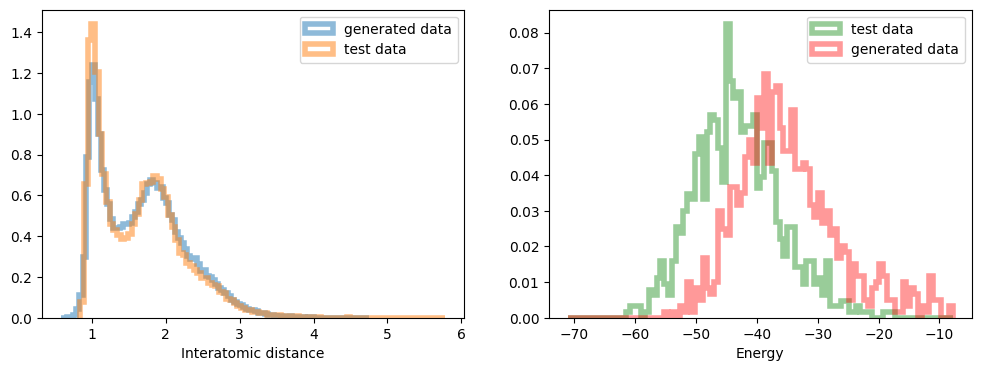

 18%|█▊        | 9/50 [12:12<59:03, 86.42s/it]

Mean of Energy tensor(30.6161, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 28.959278
Epoch 49 | Loss 27.285742
Epoch 98 | Loss 28.407984


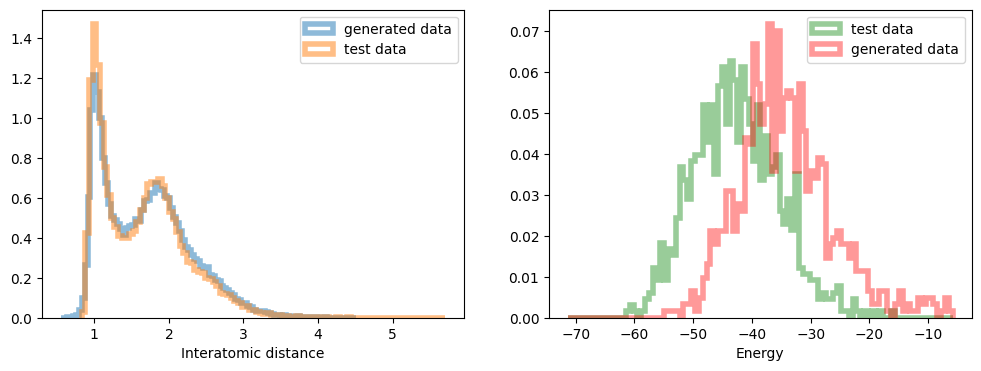

 20%|██        | 10/50 [13:41<58:00, 87.02s/it]

Mean of Energy tensor(26.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 29.356771
Epoch 49 | Loss 31.854916
Epoch 98 | Loss 30.944105


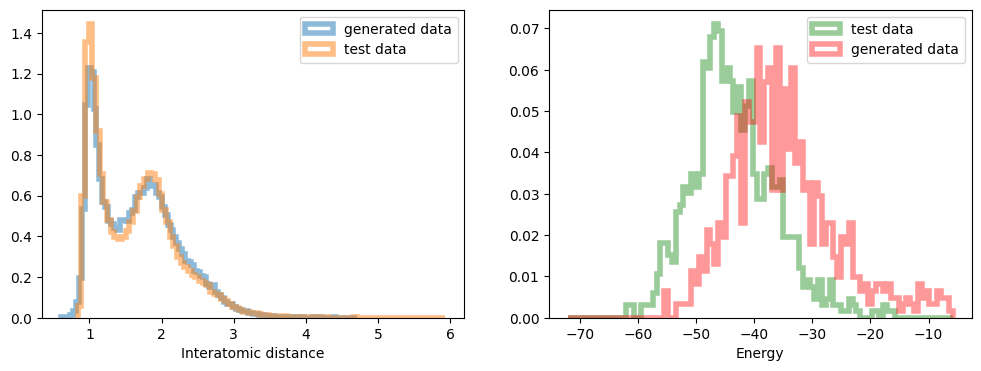

 22%|██▏       | 11/50 [15:09<56:46, 87.34s/it]

Mean of Energy tensor(26.7585, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 32.625751
Epoch 49 | Loss 28.283236
Epoch 98 | Loss 29.954805


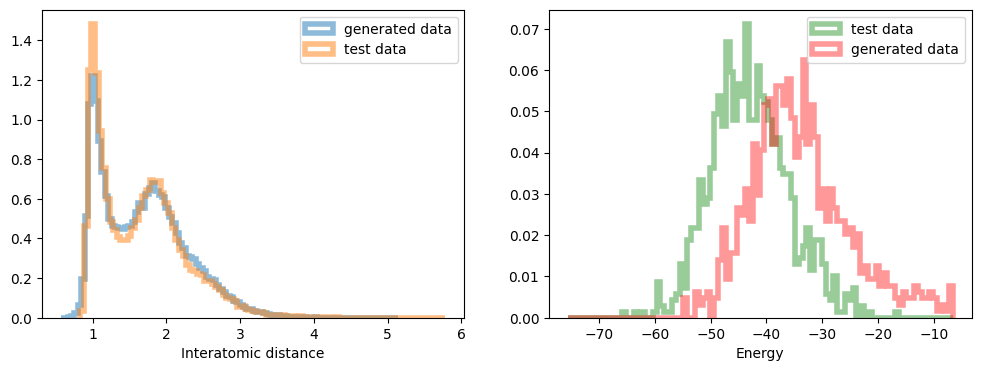

 24%|██▍       | 12/50 [16:37<55:31, 87.67s/it]

Mean of Energy tensor(25.8328, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 33.416950
Epoch 49 | Loss 31.245756
Epoch 98 | Loss 32.072041


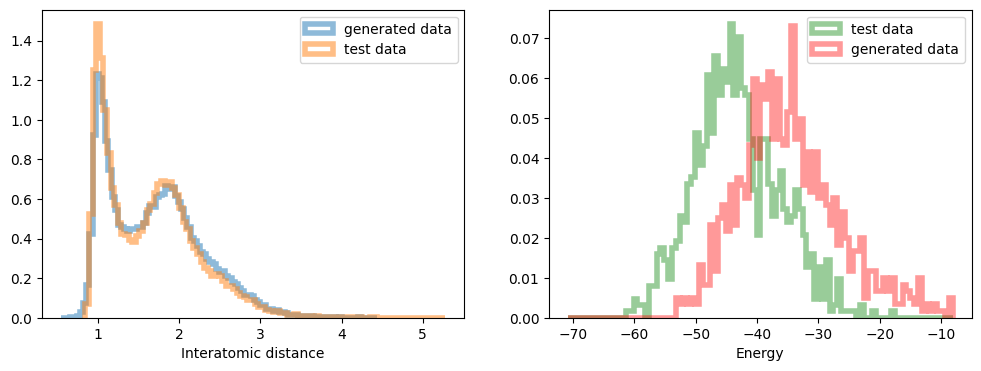

 26%|██▌       | 13/50 [18:06<54:11, 87.87s/it]

Mean of Energy tensor(27.5378, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 31.854490


 26%|██▌       | 13/50 [18:10<51:44, 83.90s/it]


KeyboardInterrupt: 

In [28]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            rm_loss= reward_matching_loss(model, 
                                          target,
                                          samples,
                                          t, 
                                          noise_schedule, 
                                          num_mc_samples=num_mc_samples,
                                          clipper=clipper
                                          )
            
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                           resampling_interval=None, num_samples=1000)
    samples_energy = target(samples)
    target.get_dataset_fig(samples)
    plt.show()


    # Update Buffer 
    buffer.add(samples,  samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 5)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [142]:
ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
samples, drift = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                    resampling_interval=None, num_samples=100)
samples_energy = target(samples)
target.get_dataset_fig(samples)
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 79.44 GiB of which 4.00 MiB is free. Including non-PyTorch memory, this process has 73.85 GiB memory in use. Process 3923250 has 5.01 GiB memory in use. Process 3926536 has 574.00 MiB memory in use. Of the allocated memory 73.16 GiB is allocated by PyTorch, and 195.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

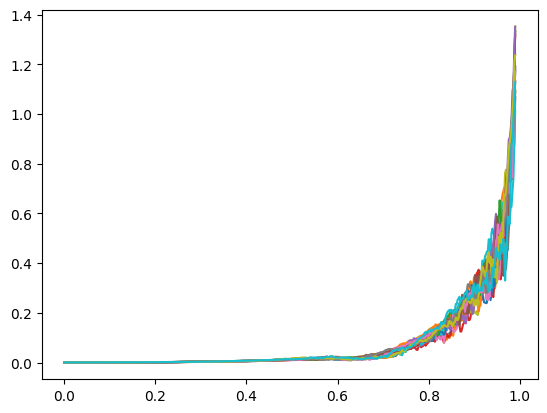

In [ ]:
drift_norm = torch.norm(drift, dim=-1)
plt.plot(torch.linspace(1, 0, 500)[5:], drift_norm.detach().cpu().numpy()[5:, :20]);

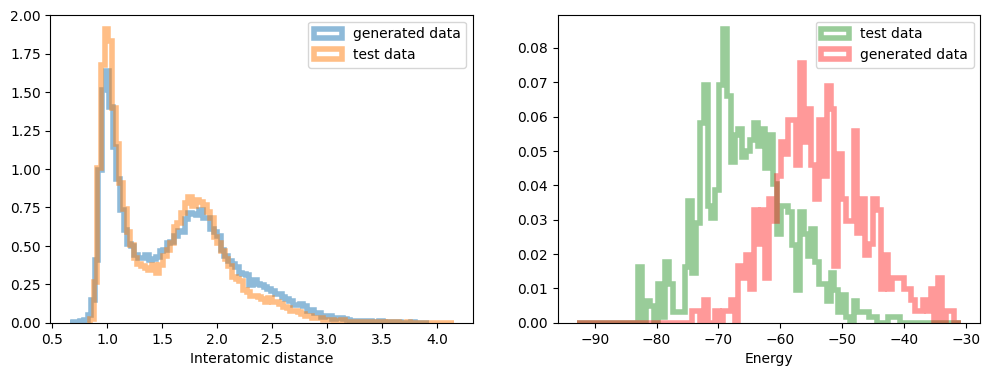

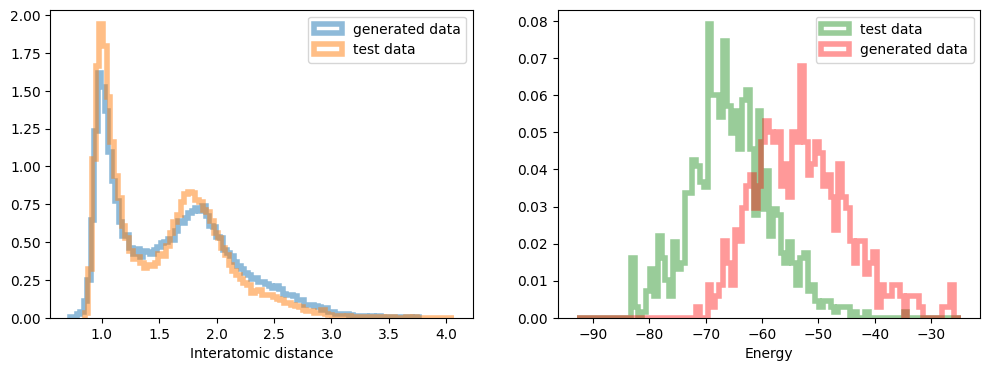

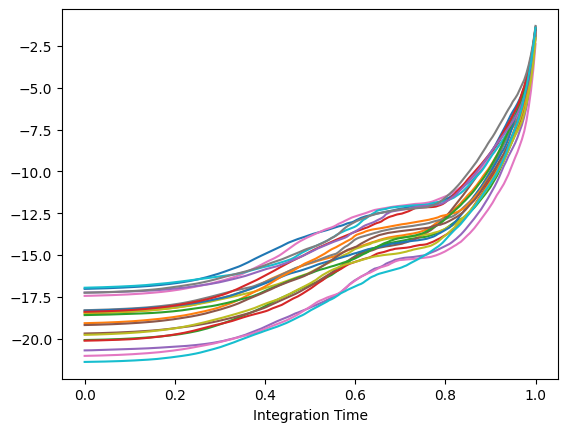

In [30]:
# for plotting

ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
n_steps = 200
samples_weighted = []
samples = []
log_weights = []
for i in range(1):
    prior_samples = prior.sample(512)
    s_weighted, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                                    num_integration_steps=n_steps, resampling_interval=1, inverse_temp=1/t_08)
    s, w = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                            num_integration_steps=n_steps, resampling_interval=n_steps+1, inverse_temp=1/t_08)
    samples_weighted.append(s_weighted)
    samples.append(s)
    log_weights.append(w)

samples_weighted = torch.cat(samples_weighted)
samples = torch.cat(samples)
log_weights = torch.cat(log_weights, dim=1)

target_temp_08.get_dataset_fig(samples_weighted)
# target_temp1.get_dataset_fig(samples_weighted, T=T, T_og=T)
plt.show()

# target.get_dataset_fig(samples, T=T, T_og=T)
target_temp_08.get_dataset_fig(samples)
plt.show()
plt.plot(torch.linspace(1, 0, n_steps)[:], log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")

plt.show()


In [19]:
target_lowtemp = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=1.0
    )

samples_energy = target_lowtemp(samples)
samples_weighted_energy = target_lowtemp(samples_weighted)

print("Mean of Energy", samples_energy.mean())
print("Mean of Energy", samples_weighted_energy.mean())
print("True Mean Energy", target_lowtemp(target.test_set).mean())

Mean of Energy tensor(34.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Mean of Energy tensor(30.9028, device='cuda:0', grad_fn=<MeanBackward0>)
True Mean Energy tensor(43.1270, device='cuda:0')
